# Topic modelling COVID-19 Kaggle dataset with Top2Vec

### Author: Dimo Angelov

### License: BSD 3 clause


Top2Vec creates jointly embedded topic, document and word vectors.

This notebook preprocesses the [Kaggle COVID-19 Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge), it treats each section of every paper as a distinct document. The Top2Vec algorithm is applied to those documents. 

The notebook allows for interacting with the trained model by searching for documents by topic, searching for documents with keywords, searching for topics with keywords, and for finding similar words. These methods all leverage the joint topic, document, word embeddings distances, which represent semantic similarity. 



# Imports and Set-up

In [0]:
!pip install git+https://github.com/lmcinnes/umap.git@0.4dev
!pip install hdbscan
!pip install datashader
!pip install holoviews
!pip install gensim

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gensim
import umap
import hdbscan
import umap.plot
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import os
import json
from google.colab import files
import ipywidgets as widgets
from IPython.display import clear_output, display
from IPython.core.display import HTML

# Call once to configure Bokeh to display plots inline in the notebook.
output_notebook()

# Preprocess Covid-19 Data

[Kaggle COVID-19 Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)

In [0]:
!unzip sample_data/CORD-19-research-challenge.zip
hover_df = pd.read_csv("/content/2020-03-13/all_sources_metadata_2020-03-13.csv")
hover_df.shape

In [0]:
# commercial datasets
comm_dir = "/content/2020-03-13/comm_use_subset/comm_use_subset/"
filenames_com = os.listdir(comm_dir)
filesnames_com = [comm_dir+filename for filename in filenames_com]

# non-commercial datasets
noncomm_dir = "/content/2020-03-13/noncomm_use_subset/noncomm_use_subset/"
filenames_noncom = os.listdir(noncomm_dir)
filesnames_noncom = [noncomm_dir+filename for filename in filenames_noncom]

# custom datasets
custom_dir = "/content/2020-03-13/pmc_custom_license/pmc_custom_license/"
filenames_custom = os.listdir(custom_dir)
filesnames_custom = [custom_dir+filename for filename in filenames_custom]

# bioarxiv datasets
biorxiv_dir = "/content/2020-03-13/biorxiv_medrxiv/biorxiv_medrxiv/"
filenames_bio = os.listdir(biorxiv_dir)
filesnames_bio = [biorxiv_dir+filename for filename in filenames_bio]

In [4]:
%%time
# parse datasets and split into sections
filenames = filesnames_com + filesnames_noncom + filesnames_custom + filesnames_bio

papers_with_text = list(data_df[data_df.has_full_text==True].sha)

paper_ids = []
titles = []
abstracts = []
sections = []
body_texts = []

for filename in filenames:

  file = json.load(open(filename, 'rb'))

  
  #check if file contains text
  if file["paper_id"] in papers_with_text:

    section = []
    text = []

    for bod in file["body_text"]:
      section.append(bod["section"])
      text.append(bod["text"])

    res_df = pd.DataFrame({"section":section, "text":text}).groupby("section")["text"].apply(' '.join).reset_index()

    for index, row in res_df.iterrows():

      # metadata
      paper_ids.append(file["paper_id"])

      if(len(file["abstract"])):
        abstracts.append(file["abstract"][0]["text"])
      else:
        abstracts.append("")

      titles.append(file["metadata"]["title"])

      # add section and text
      sections.append(row.section)
      body_texts.append(row.text)

CPU times: user 1min 31s, sys: 1.82 s, total: 1min 33s
Wall time: 1min 33s


In [5]:
# create data frame and filter very short sections
parsed_df = pd.DataFrame({"id":paper_ids, "title": titles, "abstract": abstracts, "section": sections, "text": body_texts})
parsed_df["token_counts"] = parsed_df["text"].str.split().map(len)
parsed_df = parsed_df[parsed_df.token_counts>200].reset_index(drop=True)
data_df = parsed_df
data_df.head()

id  ... token_counts
0  2ca680635b3f3dcf21ea32eca2ef05b3ef44d3ec  ...          203
1  2ca680635b3f3dcf21ea32eca2ef05b3ef44d3ec  ...          414
2  2ca680635b3f3dcf21ea32eca2ef05b3ef44d3ec  ...          439
3  2ca680635b3f3dcf21ea32eca2ef05b3ef44d3ec  ...          414
4  2ca680635b3f3dcf21ea32eca2ef05b3ef44d3ec  ...          267

[5 rows x 6 columns]

# Train Top2Vec Model

## 1. Create document and word embedding with Doc2Vec

In [0]:
# train doc2vec model
train_corpus = []

for index, row in data_df.iterrows():
    train_corpus.append(gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(row["text"]), [index]))

model = gensim.models.doc2vec.Doc2Vec(documents=train_corpus, vector_size=300, min_count=50, window=15, sample=10e-5, negative=5, hs=0, workers=80, epochs=40, dm=0, dbow_words=1)

model.save("corona_body")


In [0]:
model = gensim.models.doc2vec.Doc2Vec.load("sample_data/corona_body")

## 2. Create 2D embedding of document vectors with UMAP

In [7]:
%%time
vector = np.vstack([model.docvecs[i] for i in range(model.docvecs.count)])
umap_model_2D = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit(vector)

CPU times: user 3min 48s, sys: 9.61 s, total: 3min 58s
Wall time: 2min 40s


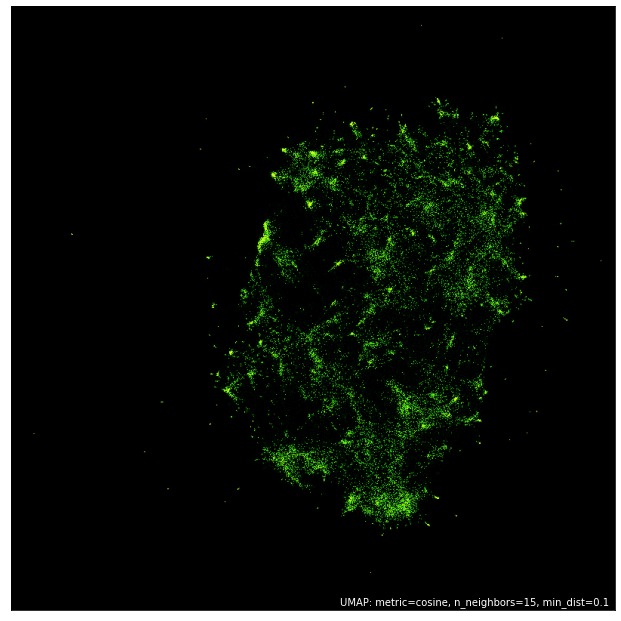

In [8]:
fig_primative = umap.plot.points(umap_model_2D, theme="darkgreen")

## 3. Find dense areas of documents with HDBSCAN

In [10]:
%%time
cluster = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(umap_model_2D.embedding_)
labels = pd.Series(cluster.labels_)
print("Number of -1 labels: ", len(labels[labels==-1])/len(labels))
print("Number of clusters: ", len(set(labels)))

Number of -1 labels:  0.4487538383751187
Number of clusters:  426
CPU times: user 1.81 s, sys: 982 ms, total: 2.79 s
Wall time: 6.08 s


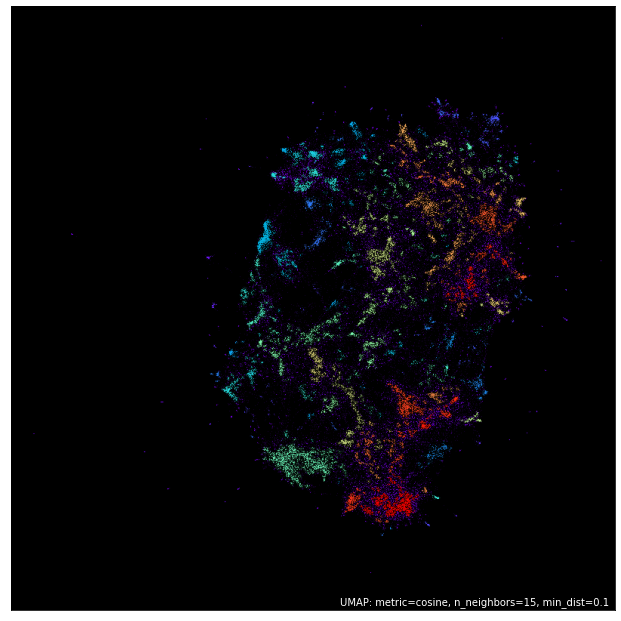

In [11]:
fig_clust = umap.plot.points(umap_model_2D,labels=labels, theme='darkgreen', show_legend=False)

## 4. Generate topic vectors from dense areas of documents

In [0]:
# Generate top2vec vectors and topic words 
# 
# Topic vectors are centroids of dense areas of documents
# Topic words are word vectors closest to topic vector

doc_group_mapping = data_df.copy()
doc_group_mapping["label"] = labels

topic_vectors = []
sim_words_l = []
top_words_l = []
topic_index = 0

# remove outlier documents as they are noise 
lables_list = list(set(labels))
lables_list.remove(-1)

for group in lables_list:
    
    # generate topic vector
    topic_vector = [0]*300
    vec_indices = doc_group_mapping[doc_group_mapping.label==group].index.tolist()
    for vec_index in vec_indices:
           topic_vector = topic_vector + model.docvecs[vec_index]
    topic_vector = topic_vector/len(vec_indices)
    
    topic_vectors.append(topic_vector)
    
    
    # find closest word vectors to topic vector
    sim_words = model.most_similar(positive=[topic_vector], topn=50)
    sim_words_l.append(sim_words)
    top_words_l.append([word[0] for word in sim_words])

# View top largest 20 topics

In [0]:
# generate word cloud for topic 
def generate_wordcloud(top_words, top_num):
    plt.figure(figsize=(16,4))
    plt.axis("off")
    plt.imshow(WordCloud(width=1600, height=400, background_color='black').generate_from_frequencies(dict(top_words)), interpolation='bilinear');
    plt.title("Topic " + str(top_num), loc='left', fontsize=20)

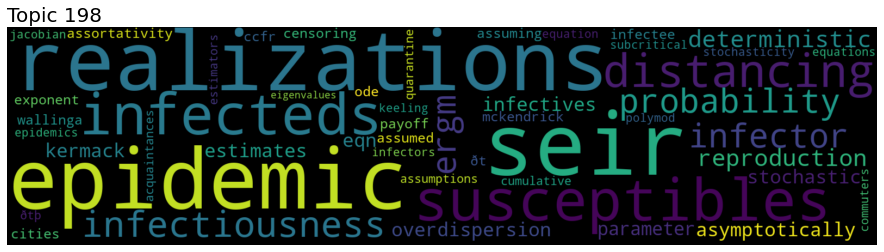

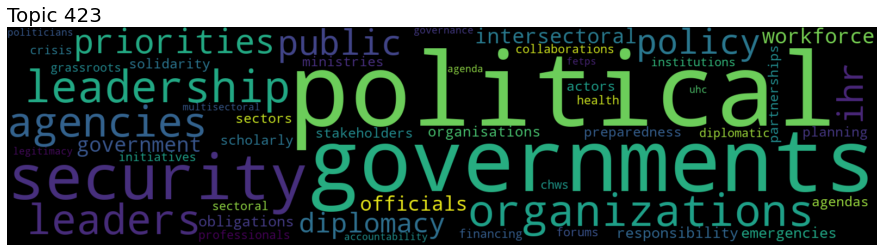

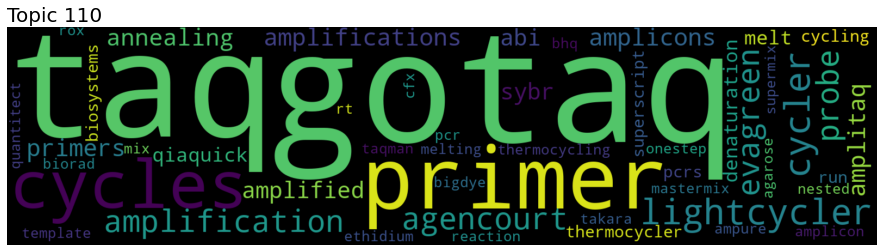

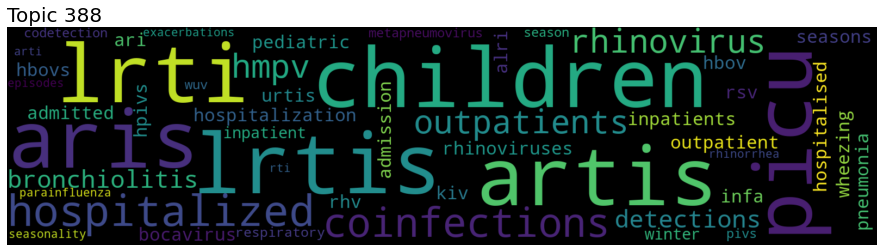

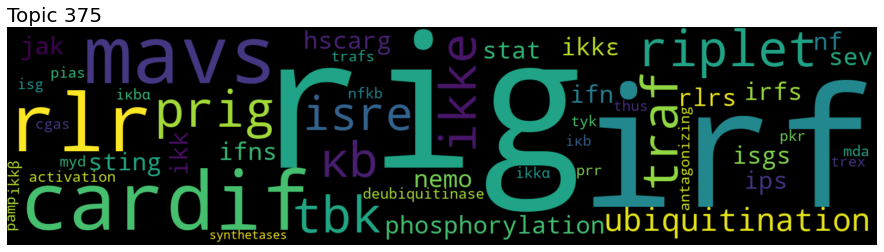

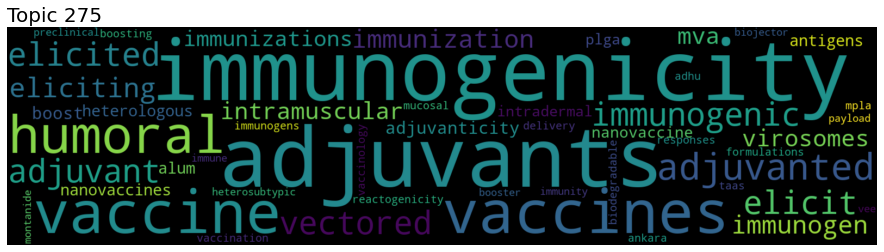

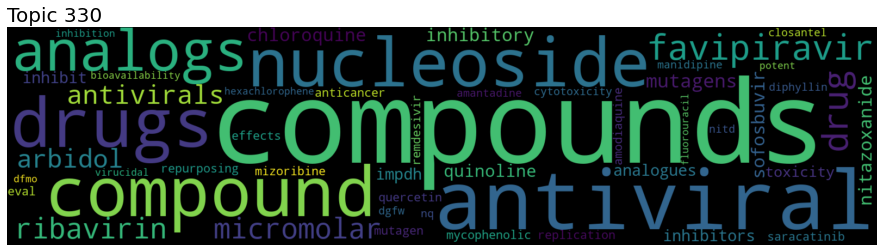

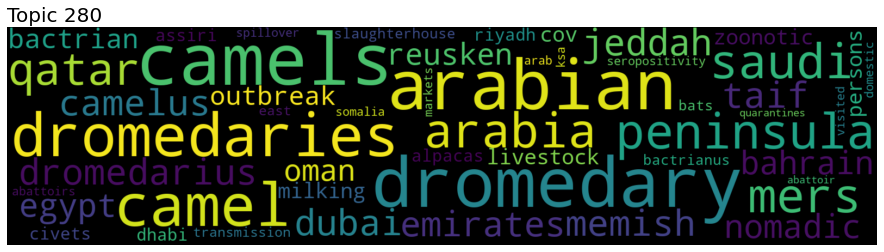

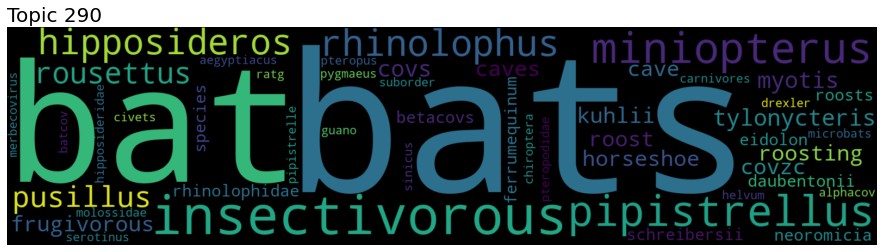

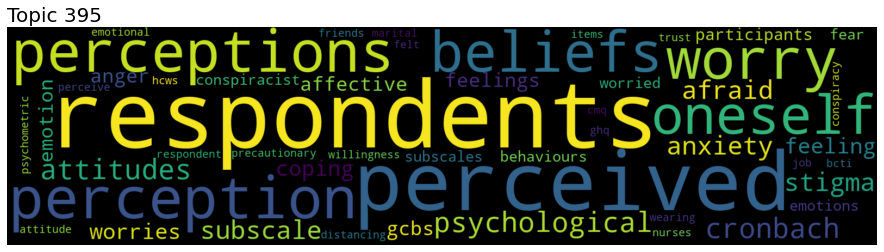

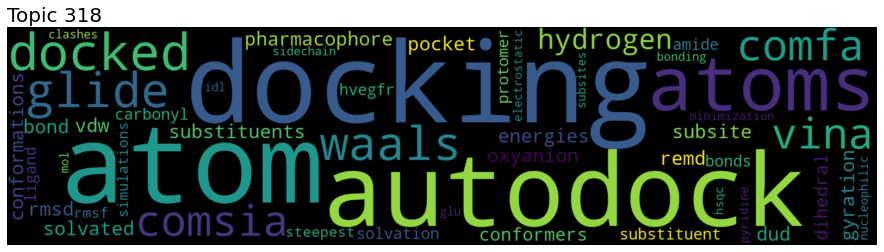

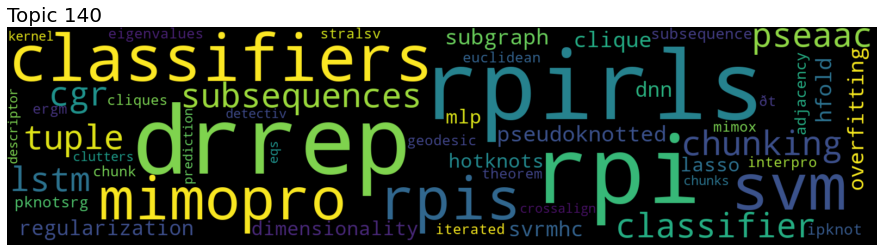

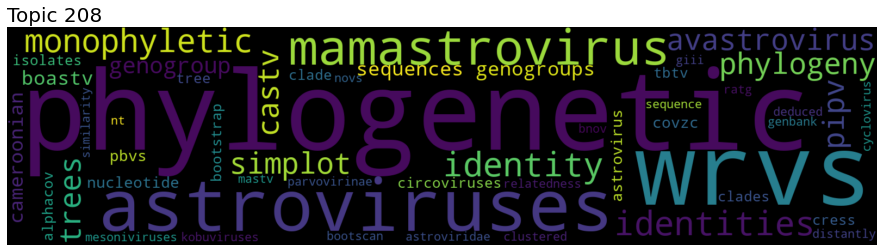

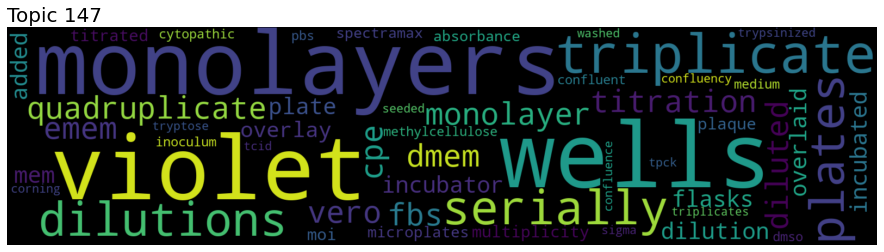

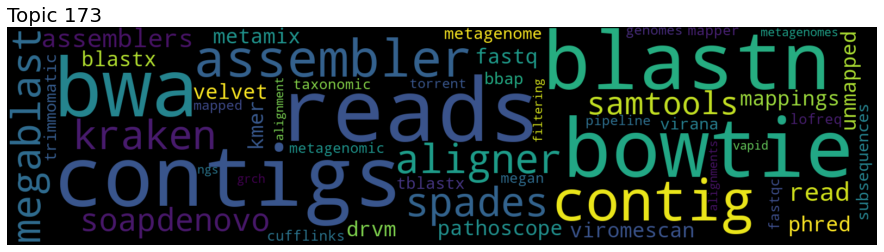

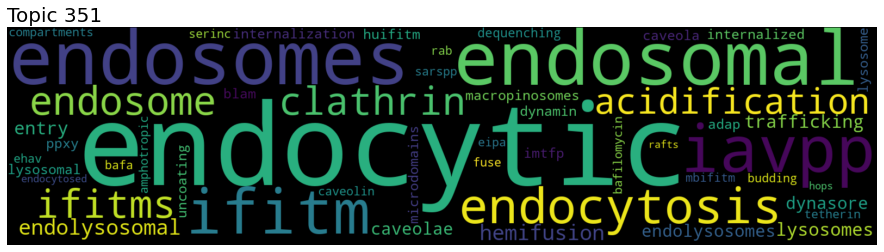

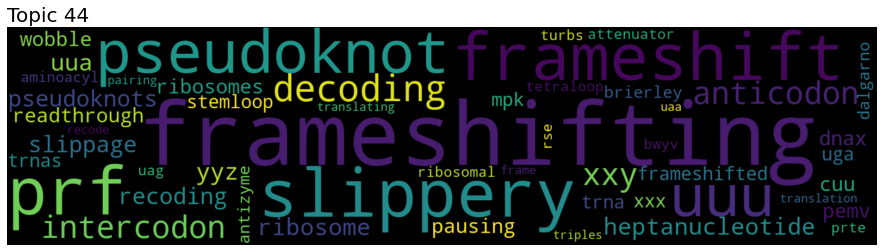

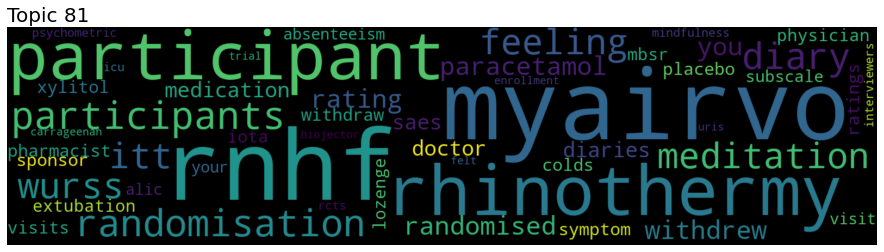

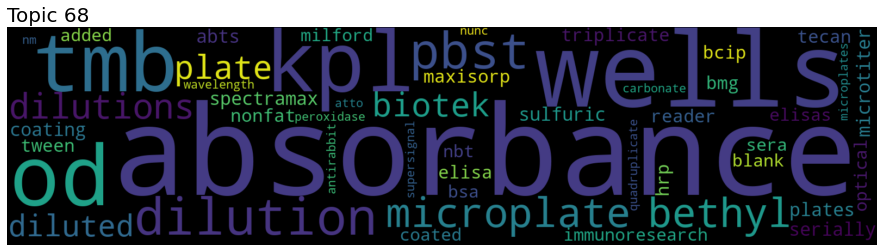

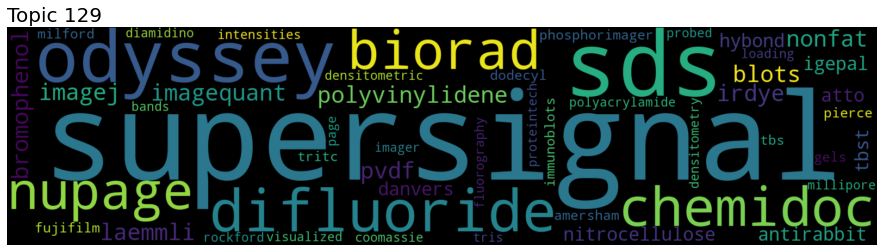

In [15]:
# order topics by size(number of documents in dense cluster)
label_df = pd.DataFrame(doc_group_mapping["label"].value_counts()).sort_values(by="label", ascending=False)
lables_list = list(label_df.index)
lables_list.remove(-1)

for group in lables_list[0:20]:
  generate_wordcloud(sim_words_l[group], group)

# Search Abstracts by Topic


In [0]:
topic_num_select = widgets.Label('Select topic number: ')
display(topic_num_select)

topic_input = widgets.Text()
display(topic_input)

doc_num_select = widgets.Label('Choose number of documents: ')
display(doc_num_select)

doc_num_input = widgets.Text(value='10')
display(doc_num_input)

def display_topics(lol):
    
    clear_output()
    display(topic_num_select)
    display(topic_input)
    display(doc_num_select)
    display(doc_num_input)
    display(topic_btn)
    
    topic_num = int(topic_input.value)
    sim_docs = model.docvecs.most_similar(positive=[topic_vectors[topic_num]], topn=int(doc_num_input.value))
    doc_list = [sim_doc[0] for sim_doc in sim_docs]

    doc_df = data_df.ix[doc_list]

    for index, row in doc_df.iterrows():
        print("_____________________________________________________________")
        print("_____________________________________________________________")
        print(row["title"] + ":")
        print(row["text"])
        print("_____________________________________________________________")
        print("_____________________________________________________________")
        print()
    
    

topic_btn = widgets.Button(description="show documents")
display(topic_btn)
topic_btn.on_click(display_topics)

Label(value='Select topic number: ')

Text(value='423')

Label(value='Choose number of documents: ')

Text(value='50')

Button(description='show documents', style=ButtonStyle())

_____________________________________________________________
_____________________________________________________________
Insights into the genetic and host adaptability of emerging porcine circovirus 3:
To investigate the forces influencing the codon usage bias of PCV3, ENC-plot analysis of the different genotypes was carried out (Figure 3 ). We found that all strains sat below the standard curve regardless of genotype. Additionally, there was also a clear separation of different genotypes except for PCV3a-IM, showing that both mutation pressure and natural selection affect the codon usage bias of different genotypes. Moreover, we carried out correlation analysis of nucleotide composition, ENC, axis1, axis2, Aroma and Gravy (Table 2) . A significant correlation was found between Gravy and ENC and GC 3s (r = −0.851, p < 0.01; r = 0.417, p < 0.01, respectively). Most of the parameters in the correlation analysis were related with each other, while Aroma only correlated with Gravy. In 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


# Search Papers by Keywords

In [0]:
keywords_select_kw = widgets.Label('Enter keywords seperated by space: ')
display(keywords_select_kw)

keywords_input_kw = widgets.Text()
display(keywords_input_kw)

keywords_neg_select_kw = widgets.Label('Enter negative keywords seperated by space: ')
display(keywords_neg_select_kw)

keywords_neg_input_kw = widgets.Text()
display(keywords_neg_input_kw)

doc_num_select_kw = widgets.Label('Choose number of documents: ')
display(doc_num_select_kw)

doc_num_input_kw = widgets.Text(value='10')
display(doc_num_input_kw)

def display_keywords(lol):
    
    clear_output()
    display(keywords_select_kw)
    display(keywords_input_kw)
    display(keywords_neg_select_kw)
    display(keywords_neg_input_kw)
    display(doc_num_select_kw)
    display(doc_num_input_kw)
    display(keyword_btn_kw)
    
    try:
        word_vecs = [model[word] for word in keywords_input_kw.value.split()]
        neg_word_vecs = [model[word] for word in keywords_neg_input_kw.value.split()]
        sim_docs = model.docvecs.most_similar(positive=word_vecs,negative=neg_word_vecs, topn=int(doc_num_input_kw.value))
        doc_list = [sim_doc[0] for sim_doc in sim_docs]


        doc_df = data_df.ix[doc_list]

        for index, row in doc_df.iterrows():
            print("_____________________________________________________________")
            print("_____________________________________________________________")
            print(row["title"] + ":")
            print(row["text"])
            print("_____________________________________________________________")
            print("_____________________________________________________________")
            print()

            
    except Exception as e:
        print(e)
        

keyword_btn_kw = widgets.Button(description="show documents")
display(keyword_btn_kw)
keyword_btn_kw.on_click(display_keywords)

Label(value='Enter keywords seperated by space: ')

Text(value='corona')

Label(value='Enter negative keywords seperated by space: ')

Text(value='')

Label(value='Choose number of documents: ')

Text(value='10')

Button(description='show documents', style=ButtonStyle())

_____________________________________________________________
_____________________________________________________________
Processing of the SARS-CoV pp1a/ab nsp7-10 region:
The human pathogenic potential of zoonotic infections by coronaviruses was exposed by the discovery of severe acute respiratory syndrome coronavirus (SARS-CoV) as causative agent of the SARS epidemic in 2003 [1, 2] . The replicase gene ORF 1ab occupies two thirds of the CoV single-strand (+)sense RNA genome. Initially, ORF1ab is directly translated into either replicase polyprotein pp1a (nsp1-11) or pp1ab (nsp1-16), depending on a ribosomal (-1)-frameshift [3] . Subsequently, the polyproteins undergo proteolytic processing into 11 or 16 individual nsp's. Eventually, the nsp's take part in forming the RTC, a membrane-anchored, highly dynamic protein-RNA complex facilitating the replicative processes [4] [5] [6] [7] . The main chymotrypsin-like protease (M pro ; nsp5) facilitates processing of the C-terminal part of

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


# Search Topics

Label(value='Enter keywords seperated by space: ')

Text(value='animal')

Label(value='Enter negative keywords seperated by space: ')

Text(value='')

Label(value='Choose number of topics: ')

Text(value='10')

Button(description='show topics', style=ButtonStyle())

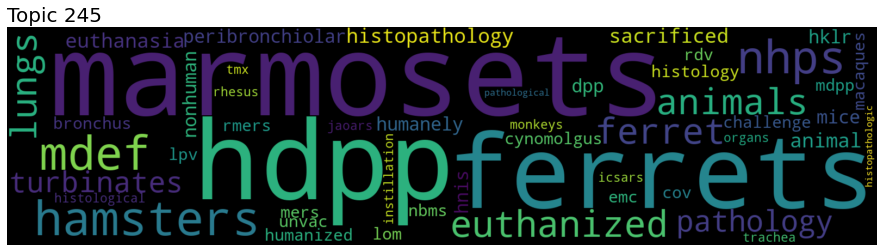

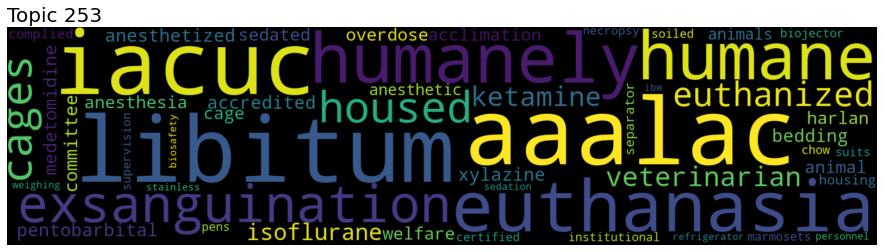

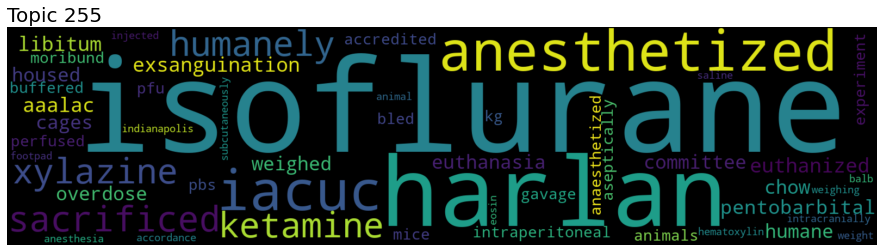

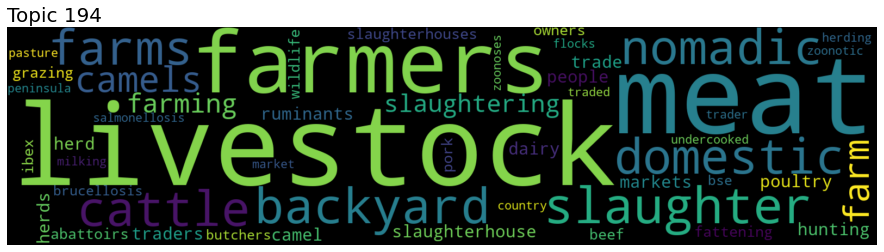

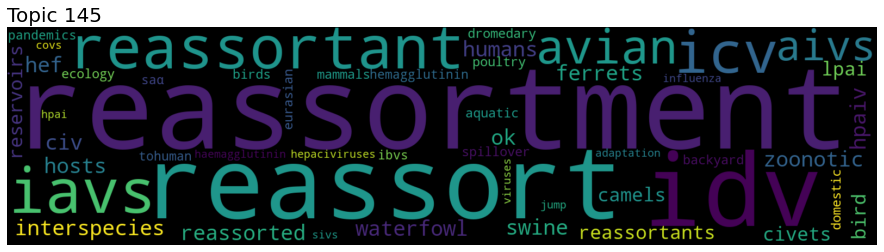

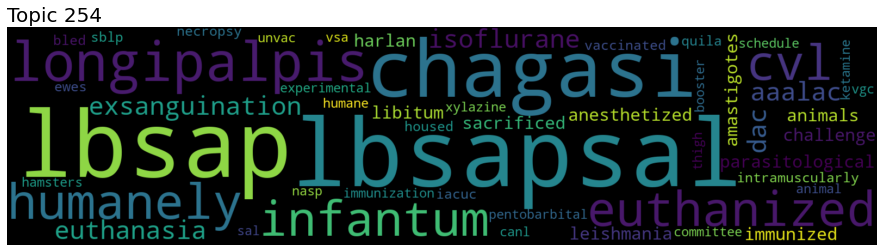

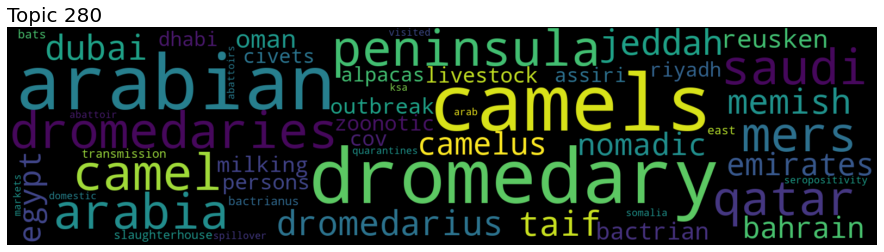

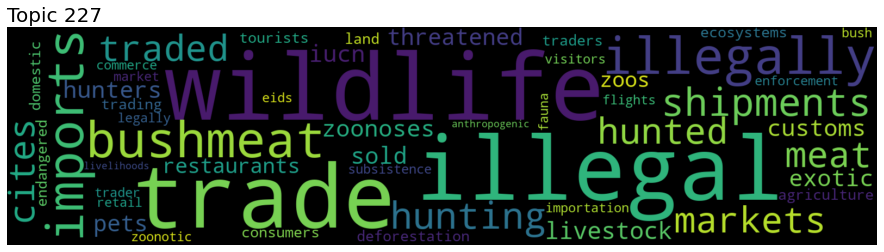

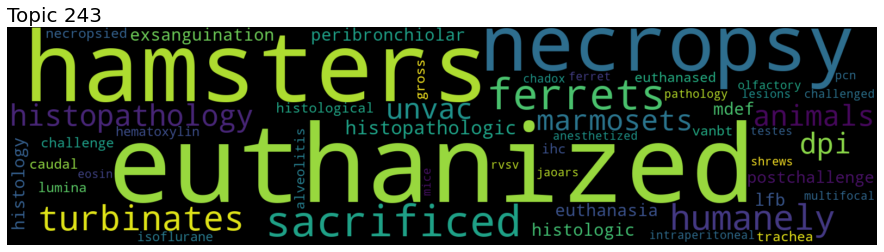

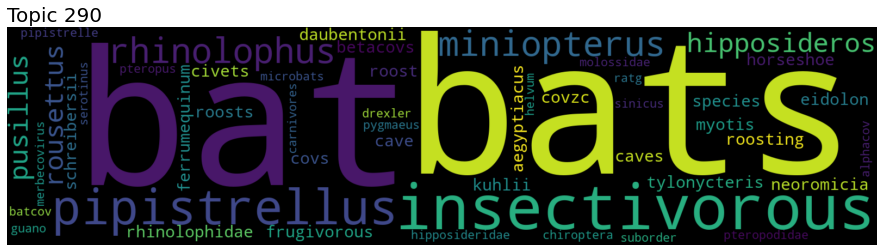

In [0]:
keywords_select_st = widgets.Label('Enter keywords seperated by space: ')
display(keywords_select_st)

keywords_input_st = widgets.Text()
display(keywords_input_st)

keywords_neg_select_st = widgets.Label('Enter negative keywords seperated by space: ')
display(keywords_neg_select_st)

keywords_neg_input_st = widgets.Text()
display(keywords_neg_input_st)

doc_num_select_st = widgets.Label('Choose number of topics: ')
display(doc_num_select_st)

doc_num_input_st = widgets.Text(value='10')
display(doc_num_input_st)

top_ranks = pd.DataFrame()

def display_similar_topics(lol):
    
    clear_output()
    display(keywords_select_st)
    display(keywords_input_st)
    display(keywords_neg_select_st)
    display(keywords_neg_input_st)
    display(doc_num_select_st)
    display(doc_num_input_st)
    display(keyword_btn_st)
    
    try:
        word_vecs = [model[word] for word in keywords_input_st.value.split()]
        neg_word_vecs = [model[word] for word in keywords_neg_input_st.value.split()]
        
        the_vector = [0]*300
        
        for word_vec in word_vecs:
            the_vector+=word_vec
            
        for word_vec in neg_word_vecs:
            the_vector-=word_vec
            
        the_vector/=(len(word_vecs)+len(neg_word_vecs))

        
        topic_scores = [topic[0] for topic in cosine_similarity(topic_vectors, the_vector.reshape(1, -1))]
        global top_ranks
        top_ranks = pd.DataFrame(topic_scores).sort_values(by=0, ascending=False)
        
        for top_num in top_ranks.index.tolist()[0:int(doc_num_input_st.value)]:
            generate_wordcloud(sim_words_l[top_num], top_num)             
        
    except Exception as e:
        print(e)
        
keyword_btn_st = widgets.Button(description="show topics")
display(keyword_btn_st)
keyword_btn_st.on_click(display_similar_topics)

# Similar Words

In [0]:
keywords_select_sw = widgets.Label('Enter keywords seperated by space: ')
display(keywords_select_sw)

keywords_input_sw = widgets.Text()
display(keywords_input_sw)

keywords_neg_select_sw = widgets.Label('Enter negative keywords seperated by space: ')
display(keywords_neg_select_sw)

keywords_neg_input_sw = widgets.Text()
display(keywords_neg_input_sw)


doc_num_select_sw = widgets.Label('Choose number of words: ')
display(doc_num_select_sw)

doc_num_input_sw = widgets.Text(value='50')
display(doc_num_input_sw)

def display_similar_words(lol):
    
    clear_output()
    display(keywords_select_sw)
    display(keywords_input_sw)
    display(keywords_neg_select_sw)
    display(keywords_neg_input_sw)
    display(doc_num_select_sw)
    display(doc_num_input_sw)
    display(sim_word_btn_sw)
    
    try:
        word_vecs = [model[word] for word in keywords_input_sw.value.split()]
        neg_word_vecs = [model[word] for word in keywords_neg_input_sw.value.split()]
        
        for word in model.most_similar(positive=word_vecs,negative=neg_word_vecs, topn=int(doc_num_input_sw.value)):
            print(word[0], " ", word[1])

        #generate_wordcloud(model.most_similar(positive=word_vecs,negative=neg_word_vecs, topn=int(doc_num_input_sw.value)), 1)
   
    except Exception as e:
        print(e)
        
sim_word_btn_sw = widgets.Button(description="show similar words")
display(sim_word_btn_sw)
sim_word_btn_sw.on_click(display_similar_words)

Label(value='Enter keywords seperated by space: ')

Text(value='flu')

Label(value='Enter negative keywords seperated by space: ')

Text(value='')

Label(value='Choose number of words: ')

Text(value='50')

Button(description='show similar words', style=ButtonStyle())

flu   0.9999999403953552
influenza   0.6697516441345215
pandemic   0.6257297992706299
seasonal   0.5730403661727905
pdm   0.5207619667053223
pandemics   0.5096025466918945
ili   0.5094633102416992
season   0.47421616315841675
avian   0.4719291925430298
swine   0.4593740999698639
uenza   0.4592532515525818
news   0.4576457142829895
epidemics   0.4498436450958252
spanish   0.4469868838787079
illness   0.4439212381839752
seasons   0.43600398302078247
people   0.4318794906139374
elderly   0.43009233474731445
kong   0.42611247301101685
subtype   0.42482054233551025
colds   0.41879919171333313
ebola   0.41870057582855225
outbreak   0.41222047805786133
illnesses   0.4114672541618347
pdmh   0.4098784327507019
tamiflu   0.40928101539611816
respiratory   0.4084645211696625
hong   0.40502363443374634
autumn   0.4029863178730011
google   0.3980070948600769
subtypes   0.3963080048561096
mexico   0.39346203207969666
participants   0.3932236135005951
symptoms   0.3911924362182617
threat   0.389892756

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
